# Investigation of the Equilibrium Paths of the Box Beam Reinforced with Ribs

In our [previous notebook](14_Investigation_of_the_Equilibrium_Paths_of_the_Unreinforced_Box_Beam.ipynb) we ascertained the existence of complimentary paths beyond the natural path for the unreinforced box beam. In this notebook we are going to perform an analogous investigation for the box beam reinforced with ribs.

* [Setup of the numerical model](#numerical-model)
* [Verification of the existence of other equilibrium paths](#verification)
* [Visualization of 3D equilibrium diagram and of deformation shapes](#visualization)
* [Conclusions](#conclusions)

## Setup of the numerical model <a name="numerical-model"></a>

***

We consider the same box beam reinforced with ribs analyzed in our [eighth notebook](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb).

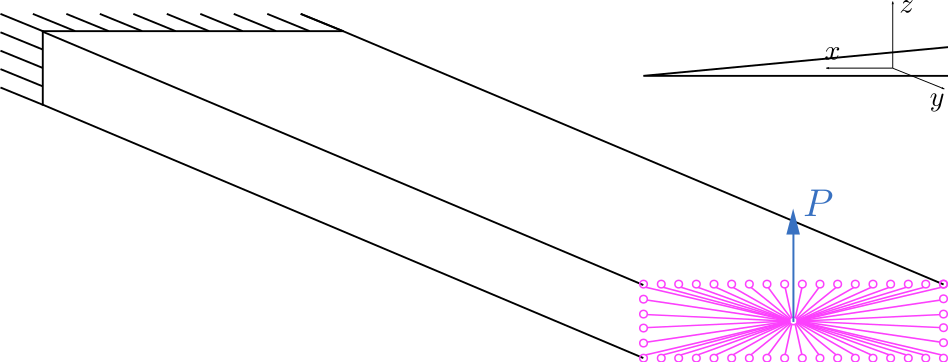

In [248]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '08_BoxBeamConcentratedLoad.svg'))

In [249]:
import numpy as np

# Define geometry
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- span: {b/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

# Define ribs location
ribs_spacing = w/2  # half of box beam's width
no_ribs = int(np.ceil(b/ribs_spacing)) + 1  # calculate number of ribs
ribs_y_locations = np.linspace(0, b, no_ribs)  # calculate y-coordinates of the ribs
np.set_printoptions(precision=0)
print(f'Number of ribs: {no_ribs:.0f}')
print(f'Ribs\' y-coordinate [mm]:')
print(ribs_y_locations)

# Define material
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

Box beam dimensions:
- width: 1.0 m
- span: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm
Number of ribs: 10
Ribs' y-coordinate [mm]:
[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]


Let's define the mesh using a shell element of 49 mm, as found in a previous [mesh convergence study](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#mesh-convergence). We use the function `mesh_box_beam_with_pyvista` from the `box_beam_utils` module and then we call the function `create_base_bdf_input` from the same module, which generates a `BDF` object of our box beam with material properties, nodes, elements, boundary conditions and output files defaults. Finally, we print the cards of the `BDF` object.

In [250]:
from resources import box_beam_utils

edge_length = 49.  # [mm]
box_beam_mesh = box_beam_utils.mesh_box_beam_with_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h, edge_length=edge_length)
nodes_coordinates_array = box_beam_mesh.points
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array,
                                                    nodes_connectivity_matrix=nodes_connectivity_matrix)
print(box_beam_bdf.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 7154

bdf.elements: 0
  CQUAD4   : 7368

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Now we add a concentrated upward force at the center of the tip section, connecting with a RBE3 element the nodes on the edge of the section to a new node in the center.

In [251]:
# Add master node of tip section
tip_master_node_id = np.size(nodes_coordinates_array, 0) + 1
box_beam_bdf.add_grid(tip_master_node_id, [w/2, b, 0.])

# Find id of the nodes on the edge of the tip rib
tolerance = edge_length/100  # we define a geometric tolerance to find the nodes on the edge of the tip rib equal to 1/100 of elements' length
tip_edge_nodes_ids = [nid for nid in box_beam_bdf.nodes if (np.abs(box_beam_bdf.nodes[nid].xyz[1] - b) < tolerance) &  # y = b
                      (np.abs((box_beam_bdf.nodes[nid].xyz[0]) < tolerance) |  # x = 0
                       (np.abs(box_beam_bdf.nodes[nid].xyz[0] - w) < tolerance) |  # x = w
                       (np.abs(box_beam_bdf.nodes[nid].xyz[2] - h/2) < tolerance) |  # z = -h/2
                       (np.abs(box_beam_bdf.nodes[nid].xyz[2] + h/2) < tolerance))]  # z = h/2

# Add RBE3 to connect master node with edge nodes of tip rib
rbe3_eid = len(box_beam_bdf.elements) + 1
box_beam_bdf.add_rbe3(eid=rbe3_eid, refgrid=tip_master_node_id, refc='123456', weights=[1.]*len(tip_edge_nodes_ids), comps=['123456']*len(tip_edge_nodes_ids),
                      Gijs=tip_edge_nodes_ids)

# Add concentrated force
force_set_id = 11
concentrated_force_magnitude = 1.
concentrated_force_direction = [0., 0., 1.]
box_beam_bdf.add_force(sid=force_set_id, node=tip_master_node_id, mag=concentrated_force_magnitude, xyz=concentrated_force_direction)

FORCE         11    7155              1.      0.      0.      1.

Finally we set up the arc-length method with default parameters calling the function `set_up_arc_length_method` from the `pynastran_utils` module.

In [252]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

pynastran_utils.set_up_arc_length_method(box_beam_bdf)  # set up SOL 106 with arc-length method using default parameters

## Verification of the existence of other equilibrium paths <a name="verification"></a>

***

In a [previous sensitivity study](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#nonlinear-analysis-parameters) of the nonlinear analysis parameters we obtained different load-displacement curves for different combination of convergence tolerances. While we previously attributed this discrepancy to the accuracy of the nonlinear solution, now we are going to investigate whether the equilibrium points actually belong to different equilibrium paths.

We are going to start with a first analysis using $EPSP=10^{-1} and EPSW=10^{-1}$. We define two subcases with the following nonlinear analysis parameters:

1. concentrated tip load, $EPSP=10^{-1}, EPSW=10^{-1}$, default remaining parameters;
2. no load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$.

In the second subcase we use $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$ to obtain a very fine resolution of the equilibrium path while unloading the structure.

Let's recall the buckling load predicted by SOL 105 and create the two subcases.

In [253]:
# Create first subcase
sol_105_buckling_load = 3094.  # [N]
load_set_id = force_set_id + 1  # define id of LOAD card
box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[2*sol_105_buckling_load], load_ids=[force_set_id])  # add LOAD card to define load set
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=1, load_set_id=load_set_id)  # create subcase with defined load set
box_beam_bdf.nlparms[1].eps_p = 1e-1  # change convergence tolerance for load function
box_beam_bdf.nlparms[1].eps_w = 1e-1  # change convergence tolerance for energy function

# Create second subcase
zero_load_set_id = load_set_id + 1  # id of LOAD card
box_beam_bdf.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[force_set_id])  # add LOAD card with zero applied load
second_subcase_id = 2
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=second_subcase_id, load_set_id=zero_load_set_id)  # create subcase with zero applied load
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, nlparm_id=second_subcase_id, eps_p=1e-3, eps_w=1e-7, ninc=100, desiter=5, maxalr=1.01, maxinc=52,
subcase_id=second_subcase_id)  # set up arc-length method for second subcase using parameters for very fine resolution of equilibrium path

Let's run the analysis by calling the function `run_tangent_stiffness_matrix_eigenvalue_calculation` from the `pynatran_utils` module, using `no_eigenvalues=10` to calculate the 10 lowest eigenvalue of the tangent stiffness matrix, $\mathbf{K_T}$, at each converged iteration.

In [254]:
from resources import pynastran_utils

# Define analysis directory
analysis_directory_name = '15_Investigation_of_the_Equilibrium_Paths_of_the_Box_Beam_Reinforced_with_Ribs'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)

# Run analysis
no_eigenvalues = 10
input_name = 'path_existence_verification_2Psol105_epsp1e-1'
sol_106_op2_2Psol105_epsp1em1 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=zero_load_set_id + 1,
analysis_directory_path=analysis_directory_path, input_name=input_name, no_eigenvalues=no_eigenvalues, run_flag=False)

Nastran job path_existence_verification_2Psol105_epsp1e-1.bdf completed
Wall time: 404.0 s


Similarly to our last notebook, now we want to plot the load-displacement diagram and the eigenvalues of the tangent stiffness matrix and we define two functions to do that: `plot_load_displacement_diagram` and `plot_tangent_stiffness_matrix_eigenvalues`.

In [255]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles
import matplotlib.pyplot as plt

component_index = 2  # used to select translation along the z-axis for both applied loads and displacements
markers = list(Line2D.markers.keys())[2:]  # list of marker characters
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # retrieve list with succession of standard matplotlib colors

def plot_load_displacement_diagram(disp, loads):
    load_displacement_ax = plt.subplot()  # create figure with one subplot
    for subcase in loads:  # iterate through the subcases
        load_displacement_ax.plot(disp[subcase][:, component_index], loads[subcase][:, component_index]/sol_105_buckling_load, marker=markers[subcase - 1],
                                   label=f'Subcase {subcase:d}')  # plot applied loads against displacement for each converged iteration
    load_displacement_ax.legend()  # set up legend
    plt.xlabel('Tip displacement [mm]')
    plt.ylabel('$P/P_\mathrm{SOL\/105}$')
    plt.grid()
    plt.show()

def plot_tangent_stiffness_matrix_eigenvalues(directory_path, input_name, loads):
    # Read eigenvalues from f06 file
    f06_path = os.path.join(directory_path, input_name + '.f06')  # path to .f06 file
    eigvals = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Create figure with 2 subplots
    _, eigvals_axs = plt.subplots(nrows=1, ncols=2, sharey='all')
    iterations_count = 1
    # Divide lowest eigenvalues by subcase and plot them
    eigenvalues_count = 0
    eigenvalues_by_subcase = {}
    for subcase in loads:
        no_load_steps = len(loads[subcase])
        eigenvalues_by_subcase[subcase] = eigvals[:, eigenvalues_count:eigenvalues_count + no_load_steps]
        eigenvalues_count += no_load_steps
        # Plot eigenvalues vs iteration number in first subplot
        eigvals_axs[0].plot(np.arange(iterations_count, eigenvalues_by_subcase[subcase].shape[1] + iterations_count), eigenvalues_by_subcase[subcase].T, markers[subcase - 1],
        color=colors[subcase - 1], label=f'Subcase {subcase:d}')
        iterations_count += eigenvalues_by_subcase[subcase].shape[1]
        # Plot eigenvalues vs applied load in second subplot
        eigvals_axs[1].plot(loads[subcase][:eigenvalues_by_subcase[subcase].shape[1], component_index]/sol_105_buckling_load, eigenvalues_by_subcase[subcase].T,
        markers[subcase - 1], color=colors[subcase - 1])
    # Set plot appearance
    eigvals_axs[0].set_xlabel('Iteration')
    eigvals_axs[0].set_ylabel('$\mathbf{K_T}$ eigenvalues')
    eigvals_axs[0].grid(visible=True)
    eigvals_axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
    eigvals_axs[1].grid(visible=True)
    plt.show()

Let's read the load-displacement history from the `OP2` object returned by the function `run_tangent_stiffness_matrix_eigenvalue_calculation` and plot both the load-displacement and the eigenvalue diagram.

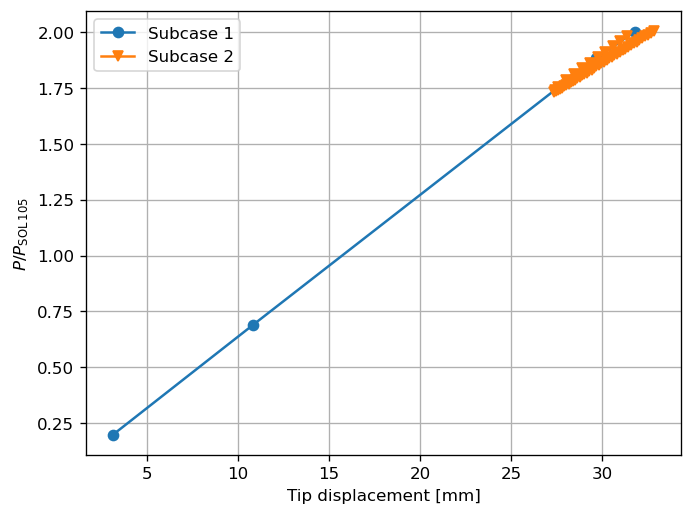

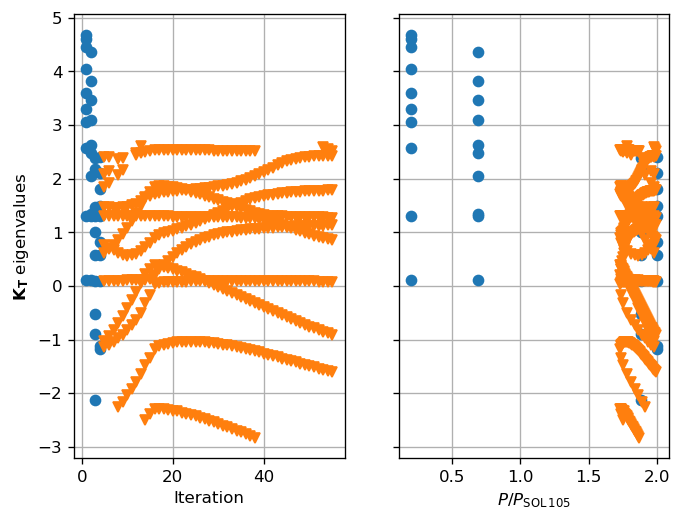

In [256]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120  # set default dpi of figures
_, applied_loads_2Psol105_epsp1em1, tip_displacements_2Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_2Psol105_epsp1em1,
                                                                                                                                  displacement_node_id=tip_master_node_id)
plot_load_displacement_diagram(tip_displacements_2Psol105_epsp1em1, applied_loads_2Psol105_epsp1em1)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_2Psol105_epsp1em1)

From this plot we can observe that the first subcase lands on an unstable path, which does not appear to be connected to the ground state, as the second subcase shows. The applied loads and displacements reach a minimum around $P/P_\text{SOL 105}=1.75$ and then spring back along a different trajectory.

Now let's try to unload the structure with a load-controlled Newton method. In this analysis we expect to observe a jump in the diagrams around $P/P_\text{SOL 105}=1.75$. We modify our `BDF` object by removing the NLPCI card and by increasing the maximum number of iteration for each load increment. The we run the analysis and we plot the results.

Nastran job path_existence_verification_2Psol105_epsp1e-1_newton.bdf completed
Wall time: 440.0 s


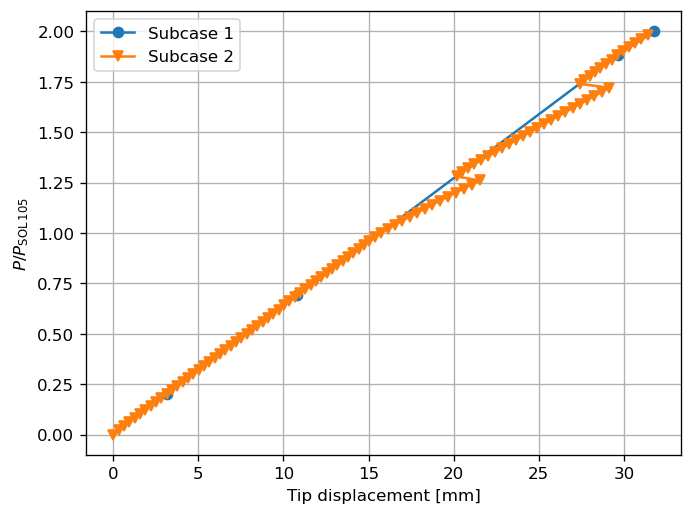

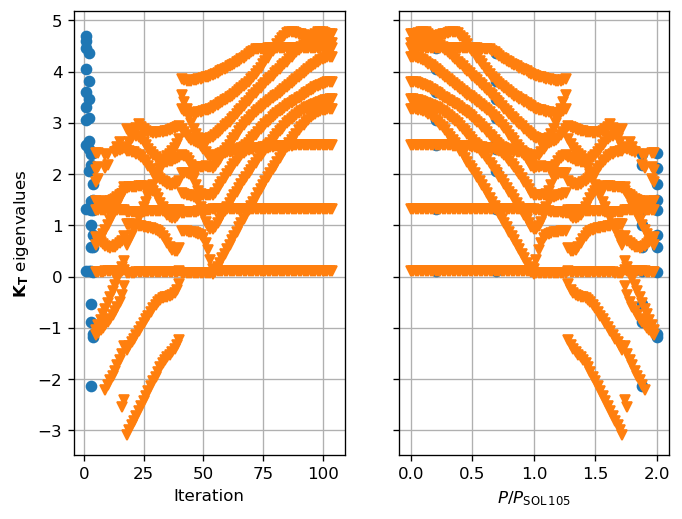

In [257]:
# Activate Newton method
del box_beam_bdf.nlpcis[second_subcase_id]  # remove NLPCI card
box_beam_bdf.nlparms[second_subcase_id].max_iter = 50  # increase maximum number of iterations for each load increment, needed to converge the iteration where the jump happens

# Run analysis
input_name = f'path_existence_verification_2Psol105_epsp1e-1_newton'
sol_106_op2_2Psol105_epsp1em1_newton = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf.__deepcopy__({}),
                                                                                                           method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues,
                                                                                                           analysis_directory_path=analysis_directory_path,
                                                                                                           input_name=input_name, run_flag=False)

# Plot results
_, applied_loads_2Psol105_epsp1em1_newton, tip_displacements_2Psol105_epsp1em1_newton = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_2Psol105_epsp1em1_newton, displacement_node_id=tip_master_node_id)
plot_load_displacement_diagram(tip_displacements_2Psol105_epsp1em1_newton, applied_loads_2Psol105_epsp1em1_newton)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_2Psol105_epsp1em1_newton)

We do not only observe a jump at $P/P_\text{SOL 105}=1.75$, but also around $P/P_\text{SOL 105}=1.25$. It is then possible that the Newton solver jumped on another unstable disconnected path at $P/P_\text{SOL 105}=1.75$, as we observe negative eigenvalues also in that segment, and successively it jumped on the natural path around $P/P_\text{SOL 105}=1.25$.

Let's verify whether we can find this additional unstable and disconnected equilibrium path. We change the applied load to $P/P_\text{SOL 105}=1.7$, reactivate the arc-length method for the second subcase, run the analysis and plot the results.

Nastran job path_existence_verification_1_7Psol105_epsp1e-1.bdf completed
Wall time: 219.0 s


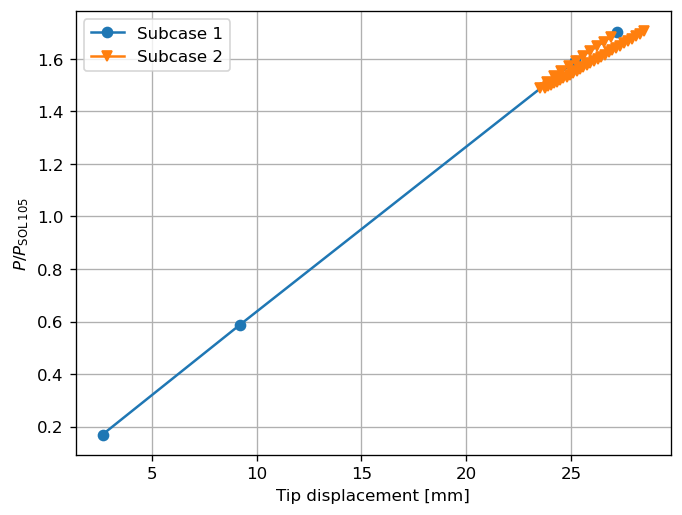

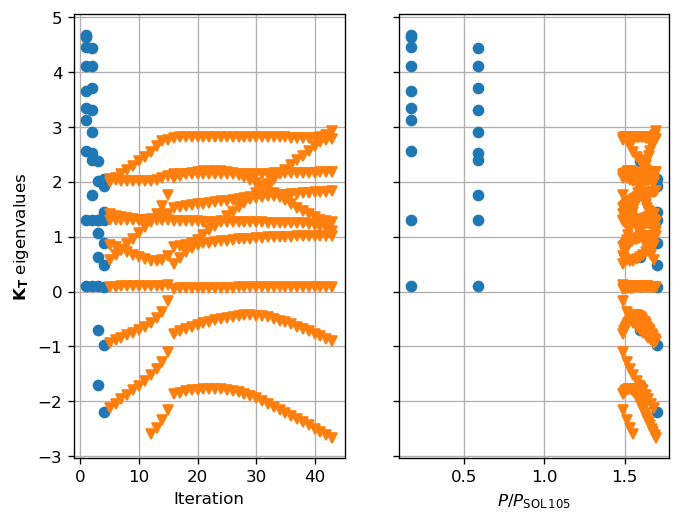

In [258]:
# Load the structure to 1.7 times the buckling load of SOL 105
load_factor = 1.7  # define multiplicative factor
box_beam_bdf.load_combinations[load_set_id][0].scale_factors[0] = sol_105_buckling_load*load_factor  # modify scale factor of LOAD card

# Reactivate arc-length method
box_beam_bdf.add_nlpci(nlpci_id=second_subcase_id, Type='CRIS', maxalr=1.01, desiter=5, mxinc=40)  # add NLPCI card for second subcase to enable arc-length method

# Run analysis
input_name = f'path_existence_verification_{load_factor:.1f}Psol105_epsp1e-1'.replace('.','_')
sol_106_op2_1_7Psol105_epsp1em1 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=zero_load_set_id + 1,
                                                                                                     no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path,
                                                                                                     input_name=input_name, run_flag=False)  # run analysis and read OP2 file

# Plot results
_, applied_loads_1_7Psol105_epsp1em1, tip_displacements_1_7Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_1_7Psol105_epsp1em1,
displacement_node_id=tip_master_node_id)  # find load and displacement history
plot_load_displacement_diagram(tip_displacements_1_7Psol105_epsp1em1, applied_loads_1_7Psol105_epsp1em1)  # plot load-displacement diagram
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_1_7Psol105_epsp1em1)  # plot eigenvalue diagram

Here we do observe another unstable disconnected path, however not the same that we were looking for. In fact, the applied loads and displacements along the path that we have just found reach a minimum at approximately $P/P_\text{SOL 105}=1.5$, while the path that we were looking for is supposed to have a minimum applied load of $P/P_\text{SOL 105}=1.25$.

Let's use the Newton method to verify the presence of a jump for the newly found path.

Nastran job path_existence_verification_1_7Psol105_epsp1e-1_newton.bdf completed
Wall time: 525.0 s


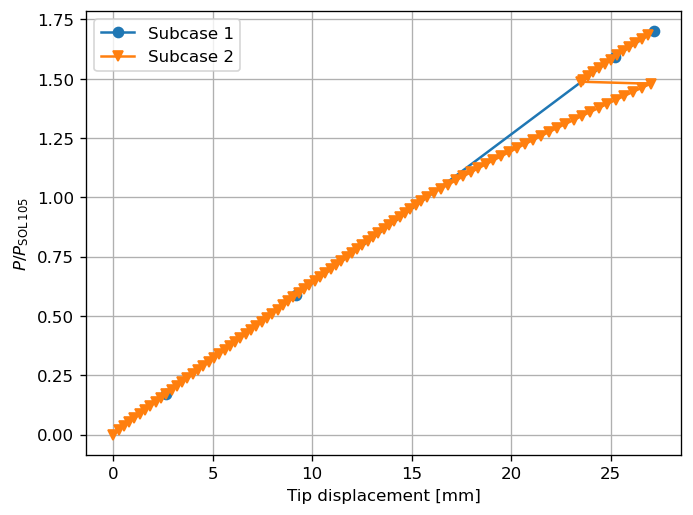

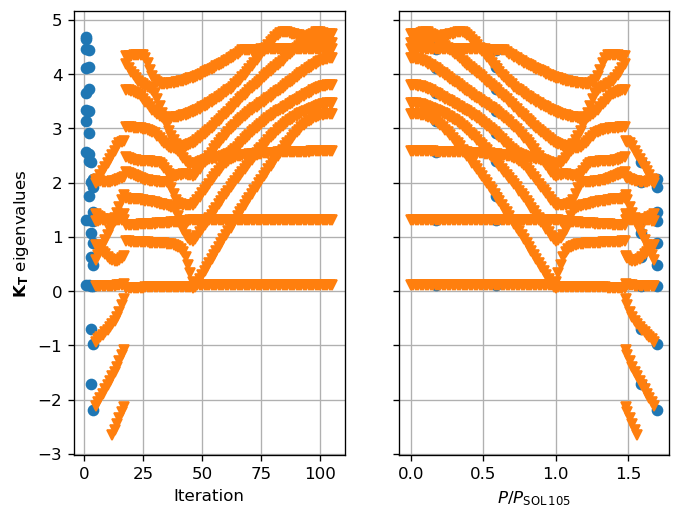

In [259]:
# Activate Newton method
del box_beam_bdf.nlpcis[second_subcase_id]  # remove NLPCI card

# Run analysis
input_name = f'path_existence_verification_{load_factor:.1f}Psol105_epsp1e-1_newton'.replace('.','_')
sol_106_op2_1_7Psol105_epsp1em1_newton = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf.__deepcopy__({}),
                                                                                                           method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues,
                                                                                                           analysis_directory_path=analysis_directory_path,
                                                                                                           input_name=input_name, run_flag=False)

# Plot results
_, applied_loads_1_7Psol105_epsp1em1_newton, tip_displacements_1_7Psol105_epsp1em1_newton = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_1_7Psol105_epsp1em1_newton, displacement_node_id=tip_master_node_id)
plot_load_displacement_diagram(tip_displacements_1_7Psol105_epsp1em1_newton, applied_loads_1_7Psol105_epsp1em1_newton)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_1_7Psol105_epsp1em1_newton)

We indeed observe a jump at $P/P_\text{SOL 105}=1.5$. Let's try now to find the other equilibrium path with a minimum applied load $P/P_\text{SOL 105}=1.25$ by loading the structure up to $P/P_\text{SOL 105}=1.4$ and unloading it with the arc-length method.

Nastran job path_existence_verification_1_4Psol105_epsp1e-1.bdf completed
Wall time: 179.0 s


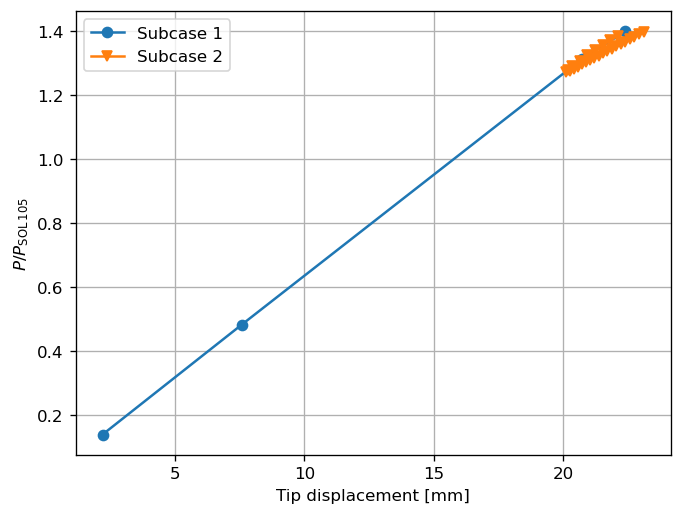

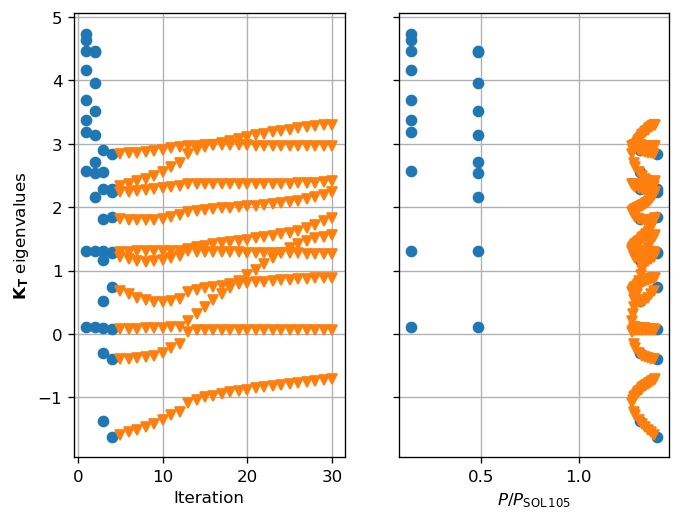

In [260]:
# Load the structure to 1.4 times the buckling load of SOL 105
load_factor = 1.4  # define multiplicative factor
box_beam_bdf.load_combinations[load_set_id][0].scale_factors[0] = sol_105_buckling_load*load_factor  # modify scale factor of LOAD card

# Reactivate arc-length method
box_beam_bdf.add_nlpci(nlpci_id=second_subcase_id, Type='CRIS', maxalr=1.01, desiter=5, mxinc=27)  # add NLPCI card for second subcase to enable arc-length method

# Run analysis
input_name = f'path_existence_verification_{load_factor:.1f}Psol105_epsp1e-1'.replace('.','_')
sol_106_op2_1_4Psol105_epsp1em1 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=zero_load_set_id + 1,
                                                                                                     no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path,
                                                                                                     input_name=input_name, run_flag=False)  # run analysis and read OP2 file

# Plot results
_, applied_loads_1_4Psol105_epsp1em1, tip_displacements_1_4Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_1_4Psol105_epsp1em1,
displacement_node_id=tip_master_node_id)  # find load and displacement history
plot_load_displacement_diagram(tip_displacements_1_4Psol105_epsp1em1, applied_loads_1_4Psol105_epsp1em1)  # plot load-displacement diagram
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_1_4Psol105_epsp1em1)  # plot eigenvalue diagram

The plots above confirm that we have found the equilibrium path with a minimum applied load of $P/P_\text{SOL 105}=1.25$. Besides, the eigenvalue diagram confirms that it is an unstable path. Let's unload the structure with the Newton method to visualize the jump.

Nastran job path_existence_verification_1_4Psol105_epsp1e-1_newton.bdf completed
Wall time: 420.0 s


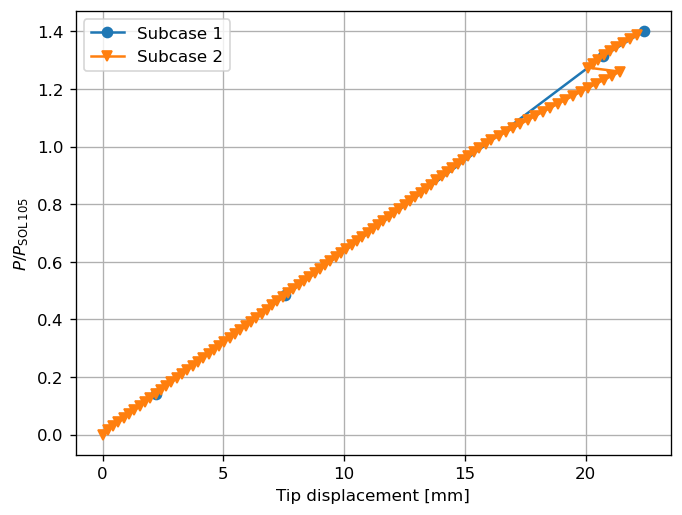

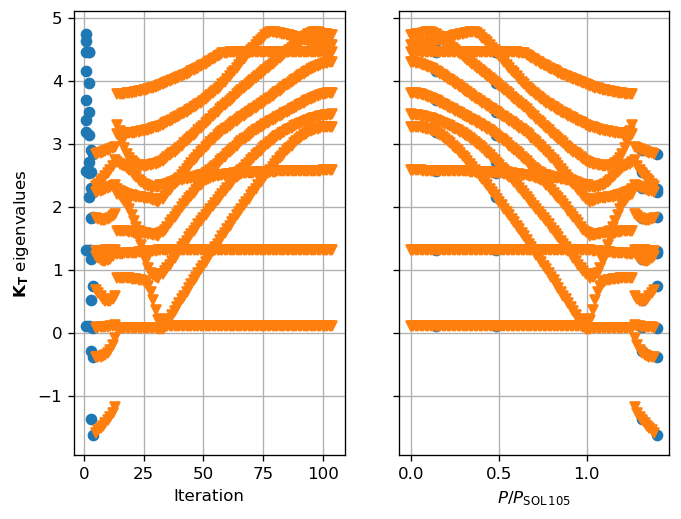

In [261]:
# Activate Newton method
del box_beam_bdf.nlpcis[second_subcase_id]  # remove NLPCI card

# Run analysis
input_name = f'path_existence_verification_{load_factor:.1f}Psol105_epsp1e-1_newton'.replace('.','_')
sol_106_op2_1_4Psol105_epsp1em1_newton = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf.__deepcopy__({}),
                                                                                                           method_set_id=zero_load_set_id+1, no_eigenvalues=no_eigenvalues,
                                                                                                           analysis_directory_path=analysis_directory_path,
                                                                                                           input_name=input_name, run_flag=False)

# Plot results
_, applied_loads_1_4Psol105_epsp1em1_newton, tip_displacements_1_4Psol105_epsp1em1_newton = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_1_4Psol105_epsp1em1_newton, displacement_node_id=tip_master_node_id)
plot_load_displacement_diagram(tip_displacements_1_4Psol105_epsp1em1_newton, applied_loads_1_4Psol105_epsp1em1_newton)
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_1_4Psol105_epsp1em1_newton)

Also in this case we can observe a jump where we expect it to be.

We skip the analysis for $EPSP=10^{-2}, EPSW=10^{-3}$ as our [previous sensitivity](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#nonlinear-analysis-parameters) study showed that these values produce the same equilibrium points as with $EPSP=10^{-1}, EPSW=10^{-1}$. We directly move on to $EPSP=10^{-3}, EPSW=10^{-7}$ with the aim of finding the natural path of the box beam.

We run the analysis with the following two subcases and plot the results:

1. concentrated tip load, $EPSP=10^{-1}, EPSW=10^{-1}$, default remaining parameters;
2. no load, $EPSP=10^{-3}, EPSW=10^{-7}, \Delta\mu^1=0.01, DESITER=5, MAXALR=1.01$.

Nastran job path_existence_verification_2Psol105_epsp1e-3.bdf completed
Wall time: 231.0 s


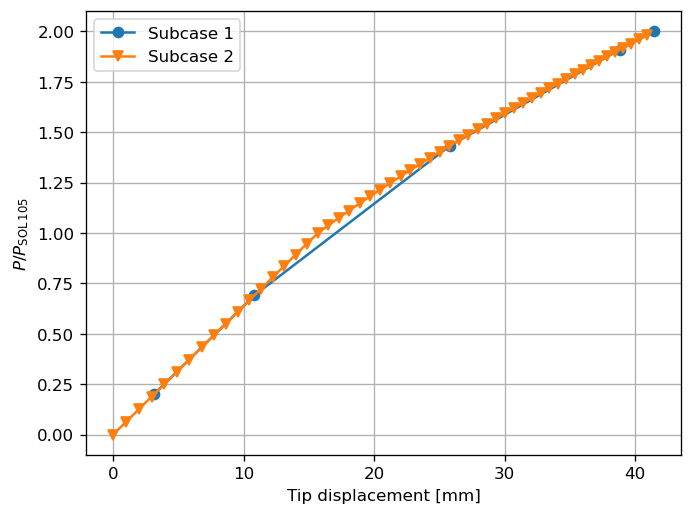

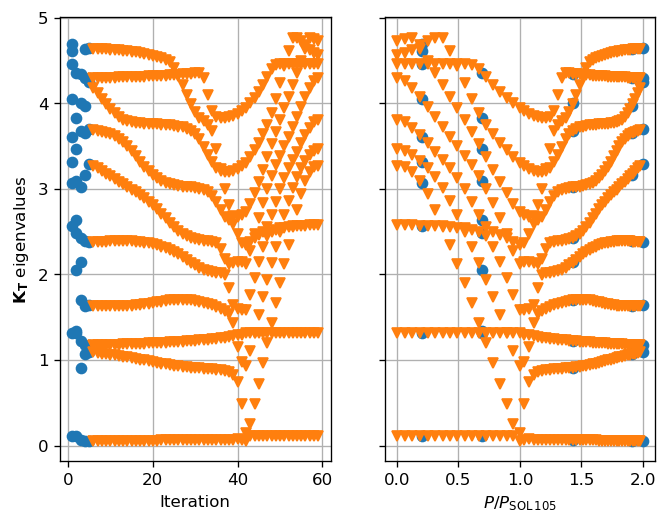

In [262]:
# Modify convergence tolerances of first subcase
box_beam_bdf.nlparms[1].eps_p = 1e-3
box_beam_bdf.nlparms[1].eps_w = 1e-7

# Reactivate arc-length method for second subcase
box_beam_bdf.add_nlpci(nlpci_id=second_subcase_id, Type='CRIS', maxalr=1.01, desiter=5, mxinc=100)

# Load the structure with twice the buckling load of SOL 105
load_factor = 2  # define multiplicative factor
box_beam_bdf.load_combinations[load_set_id][0].scale_factors[0] = sol_105_buckling_load*load_factor  # modify scale factor of LOAD card

# Run analysis
input_name = f'path_existence_verification_{load_factor:.0f}Psol105_epsp1e-3'.replace('.','_')
sol_106_op2_2Psol105_epsp1em3 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=zero_load_set_id + 1,
                                                                                                     no_eigenvalues=no_eigenvalues, analysis_directory_path=analysis_directory_path,
                                                                                                     input_name=input_name, run_flag=False)  # run analysis and read OP2 file

# Plot results
_, applied_loads_2Psol105_epsp1em3, tip_displacements_2Psol105_epsp1em3 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_2Psol105_epsp1em3,
displacement_node_id=tip_master_node_id)  # find load and displacement history
plot_load_displacement_diagram(tip_displacements_2Psol105_epsp1em3, applied_loads_2Psol105_epsp1em3)  # plot load-displacement diagram
plot_tangent_stiffness_matrix_eigenvalues(analysis_directory_path, input_name, applied_loads_2Psol105_epsp1em3)  # plot eigenvalue diagram

We indeed observe that the structure is always stable in both subcases and as a consequence we say that the equilibrium path found in the second subcase corresponds to the natural path.

## Visualization of 3D equilibrium diagram and deformation shapes <a name="visualization"></a>

***

Now we want to visualize together the natural path and the unstable paths that we found earlier. Similarly to our last notebook, we want to plot a 3D load-displacement diagram with the applied load against the tip and the local displacement, where we choose the latter to be the displacement along the $z$-axis of the node where we observe the maximum displacement in a linear buckling analysis (SOL 105).

We delete our previous subcases and call the function `run_sol_105_buckling_analysis` from the `pynastran_utils` module in order to find the id of the node where the maximum displacement occurs according to the linear buckling prediction.

In [263]:
# Delete subcases 1 and 2
for subcase_id in range(1, 3):
    del box_beam_bdf.subcases[subcase_id]

# Run linear buckling analysis
input_name = 'path_existence_verification_sol_105'
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=box_beam_bdf.__deepcopy__({}), static_load_set_id=force_set_id,
analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)

# Find id of node where maximum displacement occurs
max_displacement_node_id = np.argmax(sol_105_op2.eigenvectors[second_subcase_id].data[0, :, component_index]) + 1

Nastran job path_existence_verification_sol_105.bdf completed
Wall time: 3.0 s


Let's visualize the position of the node.

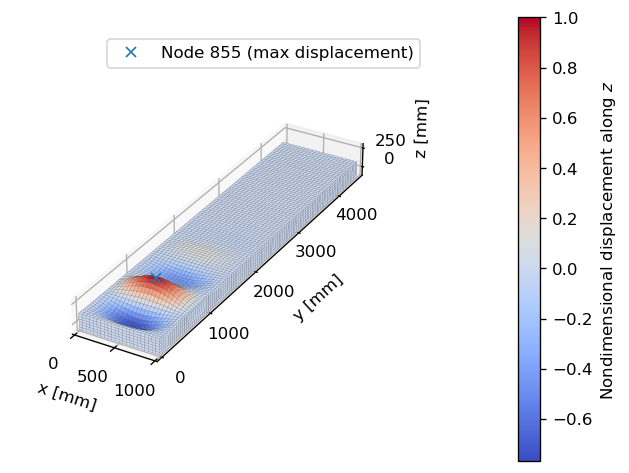

In [264]:
# Plot critical buckling mode
_, ax = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=second_subcase_id, displacement_component='tz', colormap='coolwarm')

# Plot node of max displacement
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz + 200*sol_105_op2.eigenvectors[second_subcase_id].data[0, max_displacement_node_id - 1, 0:3]  # we multiply the eigenvector by the default displacement scale factor of plot_buckling_mode
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x', label=f'Node {max_displacement_node_id:d} (max displacement)', zorder=4)
ax.legend()

# Define a function to adjust axes ticks and labels' position, that we will use also later
def set_ticks_and_labels_position(axes):
    axes.locator_params(axis='x', nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis='y', which='major', pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis='z', which='major', pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label

# Set axes ticks and labels' position and show plot
set_ticks_and_labels_position(ax)
plt.show()

The last step before producing our 3D equilibrium diagram consists in finding the local displacement history at node 855 for the natural path and the unstable paths.

In [265]:
_, _, local_displacements_natural_path = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_2Psol105_epsp1em3,
displacement_node_id=max_displacement_node_id)
_, _, local_displacements_1_4Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_1_4Psol105_epsp1em1,
displacement_node_id=max_displacement_node_id)
_, _, local_displacements_1_7Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_1_7Psol105_epsp1em1,
displacement_node_id=max_displacement_node_id)
_, _, local_displacements_2Psol105_epsp1em1 = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_2Psol105_epsp1em1,
displacement_node_id=max_displacement_node_id)

We can now produce our 3D equilibrium diagram.

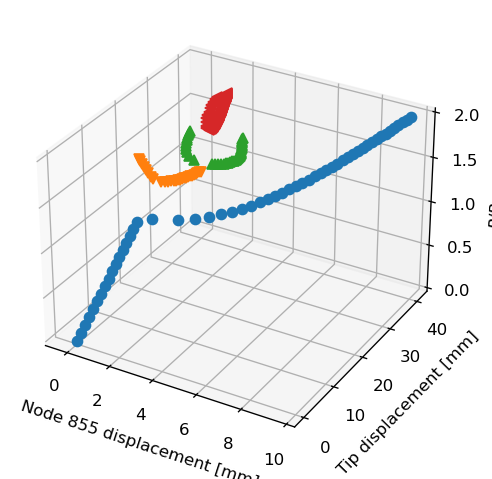

In [266]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')

# Plot applied load against tip and local displacements
local_displacements = {0: local_displacements_natural_path[second_subcase_id][:, component_index],
                       1: local_displacements_1_4Psol105_epsp1em1[second_subcase_id][:, component_index],
                       2: local_displacements_1_7Psol105_epsp1em1[second_subcase_id][:, component_index],
                       3: local_displacements_2Psol105_epsp1em1[second_subcase_id][:, component_index]}
tip_displacements = {0: tip_displacements_2Psol105_epsp1em3[second_subcase_id][:, component_index],
                     1: tip_displacements_1_4Psol105_epsp1em1[second_subcase_id][:, component_index],
                     2: tip_displacements_1_7Psol105_epsp1em1[second_subcase_id][:, component_index],
                     3: tip_displacements_2Psol105_epsp1em1[second_subcase_id][:, component_index]}
applied_loads = {0: applied_loads_2Psol105_epsp1em3[second_subcase_id][:, component_index]/sol_105_buckling_load,
                 1: applied_loads_1_4Psol105_epsp1em1[second_subcase_id][:, component_index]/sol_105_buckling_load,
                 2: applied_loads_1_7Psol105_epsp1em1[second_subcase_id][:, component_index]/sol_105_buckling_load,
                 3: applied_loads_2Psol105_epsp1em1[second_subcase_id][:, component_index]/sol_105_buckling_load}
for key in local_displacements:
    ax_3d.plot3D(local_displacements[key], tip_displacements[key], applied_loads[key], markers[key], color=colors[key])

# Set plot appearance
ax_3d.set_xlabel(f'Node {max_displacement_node_id:d} displacement [mm]')
ax_3d.set_ylabel('Tip displacement [mm]')
ax_3d.set_zlabel('$P/P_\mathrm{SOL\/105}$')
ax_3d.grid(visible=True)
plt.show()

With this plot we can get a clear visualization of the disconnected nature of the equilibrium paths. However, we should remind that the equilibrium manifold of our box beam has actually as many dimensions as the number of the degrees of freedom plus one (representing the applied load). This means that our 3D equilibrium diagram is only an extremely partial representation of the equilibrium manifold and the fact that the paths appear disconnected for the investigated range of loads and displacements does not imply that the paths might not connect eslewhere in the equilibrium manifold. Nonetheless, this result is useful to make us aware that, while we are right to expect a stable natural path without bifurcations for a box beam with a concetrated load at the tip, we might jump on another path if the arc-length is large enough to allow the solver to do so.

What is the deformation shape along the different equilibrium paths? Let's explore this by cutting the equilibrium paths with a plane at $P/P_\text{SOL 105}=1.35$.

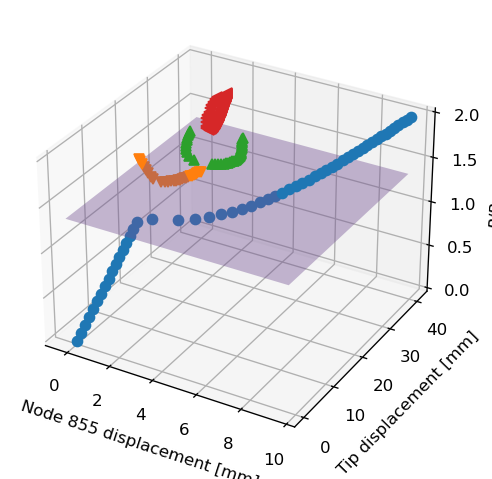

In [267]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')

# Plot part of the equilibrium paths that should not be visible on top of the plane
load_factor = 1.35
for key in local_displacements:
    ax_3d.plot3D(local_displacements[key], tip_displacements[key], np.where(applied_loads[key]<load_factor, applied_loads[key], np.nan), markers[key], color=colors[key])

# Plot plane
local_displacements_array = np.concatenate(tuple(local_displacements[key] for key in local_displacements))
tip_displacements_array = np.concatenate(tuple(tip_displacements[key] for key in tip_displacements))
xx, yy = np.meshgrid([np.min(local_displacements_array), np.max(local_displacements_array)], [np.min(tip_displacements_array), np.max(tip_displacements_array)])
ax_3d.plot_surface(xx, yy, np.full_like(xx, load_factor), alpha=0.4, color=colors[len(local_displacements)])

# Plot part of the equilibrium paths that should be visible on top of the plane
for key in local_displacements:
    ax_3d.plot3D(local_displacements[key], tip_displacements[key], np.where(applied_loads[key]>=load_factor, applied_loads[key], np.nan), markers[key], color=colors[key], zorder=3)

# Set plot appearance
ax_3d.set_xlabel(f'Node {max_displacement_node_id:d} displacement [mm]')
ax_3d.set_ylabel('Tip displacement [mm]')
ax_3d.set_zlabel('$P/P_\mathrm{SOL\/105}$')
ax_3d.grid(visible=True)
plt.show()

Let's plot the deformation shape at the closest equilibrium points to the $P/P_\text{SOL 105}=1.35$ plane.

Deformation on natural path:


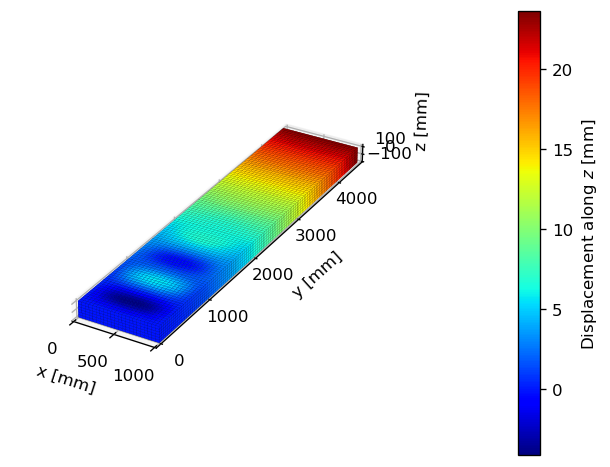

Deformations on unstable path:


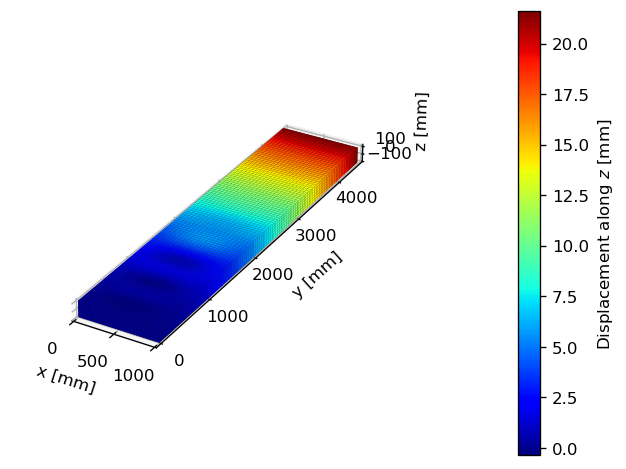

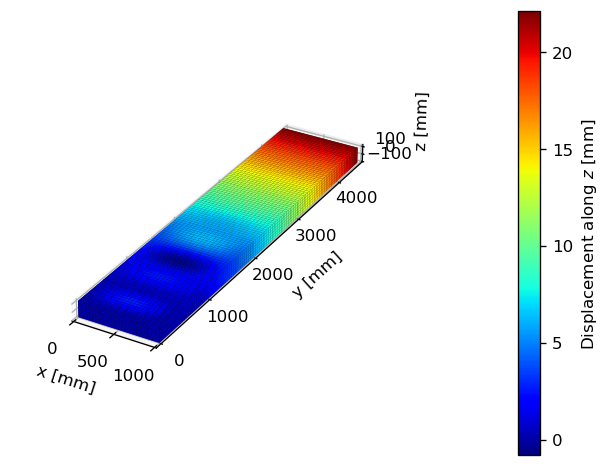

In [268]:
# Plot static deformation of natural path
print('Deformation on natural path:')
load_step = np.argmin(np.abs(applied_loads[0] - load_factor)) + 1  # find closest load step to plane
_, ax = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_2Psol105_epsp1em3, subcase_id=second_subcase_id, load_step=load_step, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

# Plot first deformation on unstable path
print('Deformations on unstable path:')
key = 1
negative_displacements_indices = np.where(local_displacements[key] < np.median(local_displacements[key]))[0]
load_step = negative_displacements_indices[np.argmin(np.abs(applied_loads[key][negative_displacements_indices] - load_factor))] + 1  # find closest load step to plane
_, ax = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_1_4Psol105_epsp1em1, subcase_id=second_subcase_id, load_step=load_step, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

# Plot second deformation on unstable path
positive_displacements_indices = np.where(local_displacements[key] > np.median(local_displacements[key]))[0]
load_step = positive_displacements_indices[np.argmin(np.abs(applied_loads[key][positive_displacements_indices] - load_factor))] + 1  # find closest load step to plane
_, ax = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_1_4Psol105_epsp1em1, subcase_id=second_subcase_id, load_step=load_step, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

Now let's plot the deformation shape at the closest equilibrium points to a plane cutting the equilibrium paths at $P/P_\text{SOL 105}=1.65$.

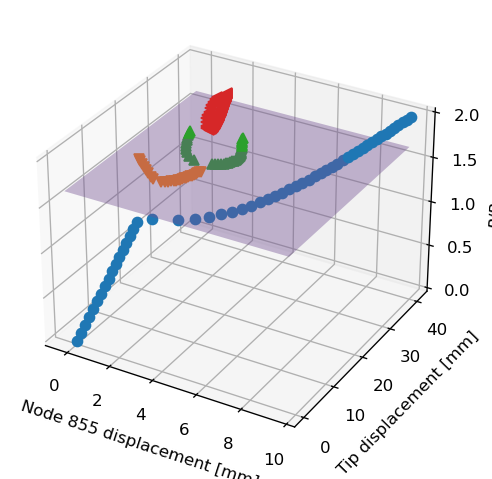

Deformation on natural path:


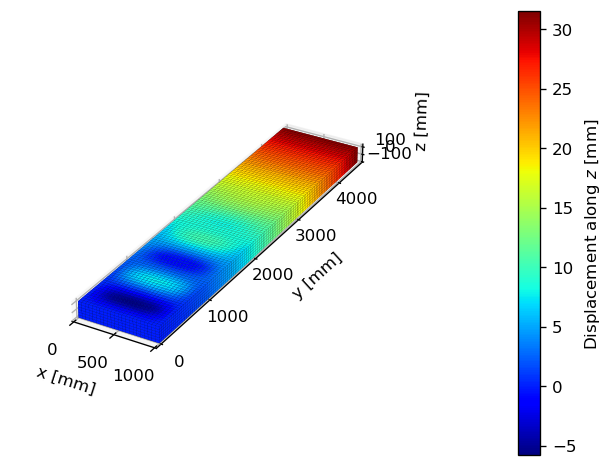

Deformations on unstable path:


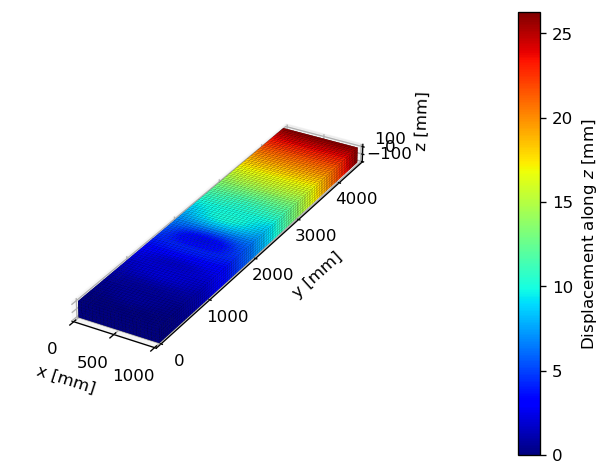

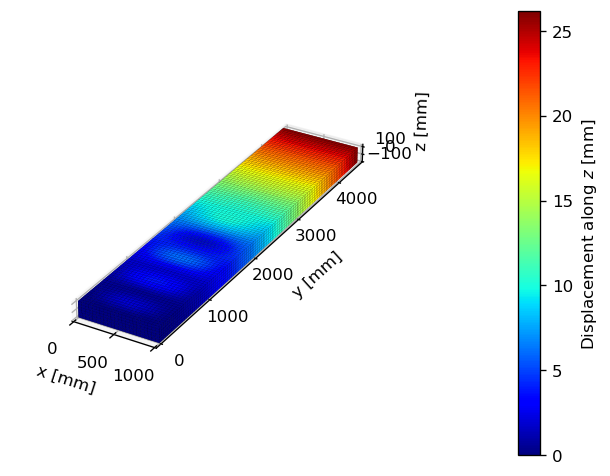

In [269]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')

# Plot part of the equilibrium paths that should not be visible on top of the plane
load_factor = 1.65
for key in local_displacements:
    ax_3d.plot3D(local_displacements[key], tip_displacements[key], np.where(applied_loads[key]<load_factor, applied_loads[key], np.nan), markers[key], color=colors[key])

# Plot plane
local_displacements_array = np.concatenate(tuple(local_displacements[key] for key in local_displacements))
tip_displacements_array = np.concatenate(tuple(tip_displacements[key] for key in tip_displacements))
xx, yy = np.meshgrid([np.min(local_displacements_array), np.max(local_displacements_array)], [np.min(tip_displacements_array), np.max(tip_displacements_array)])
ax_3d.plot_surface(xx, yy, np.full_like(xx, load_factor), alpha=0.4, color=colors[len(local_displacements)])

# Plot part of the equilibrium paths that should be visible on top of the plane
for key in local_displacements:
    ax_3d.plot3D(local_displacements[key], tip_displacements[key], np.where(applied_loads[key]>=load_factor, applied_loads[key], np.nan), markers[key], color=colors[key], zorder=3)

# Set plot appearance
ax_3d.set_xlabel(f'Node {max_displacement_node_id:d} displacement [mm]')
ax_3d.set_ylabel('Tip displacement [mm]')
ax_3d.set_zlabel('$P/P_\mathrm{SOL\/105}$')
ax_3d.grid(visible=True)
plt.show()

# Plot static deformation of natural path
print('Deformation on natural path:')
load_step = np.argmin(np.abs(applied_loads[0] - load_factor)) + 1  # find closest load step to plane
_, ax = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_2Psol105_epsp1em3, subcase_id=second_subcase_id, load_step=load_step, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

# Plot first deformation on unstable path
print('Deformations on unstable path:')
key = 2
negative_displacements_indices = np.where(local_displacements[key] < np.median(local_displacements[key]))[0]
load_step = negative_displacements_indices[np.argmin(np.abs(applied_loads[key][negative_displacements_indices] - load_factor))] + 1  # find closest load step to plane
_, ax = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_1_7Psol105_epsp1em1, subcase_id=second_subcase_id, load_step=load_step, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

# Plot second deformation on unstable path
positive_displacements_indices = np.where(local_displacements[1] > np.median(local_displacements[1]))[0]
load_step = positive_displacements_indices[np.argmin(np.abs(applied_loads[key][positive_displacements_indices] - load_factor))] + 1  # find closest load step to plane
_, ax = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_1_7Psol105_epsp1em1, subcase_id=second_subcase_id, load_step=load_step, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

And finally let's plot the deformation shape at the closest equilibrium points to a plane cutting the equilibrium paths at $P/P_\text{SOL 105}=1.9$.

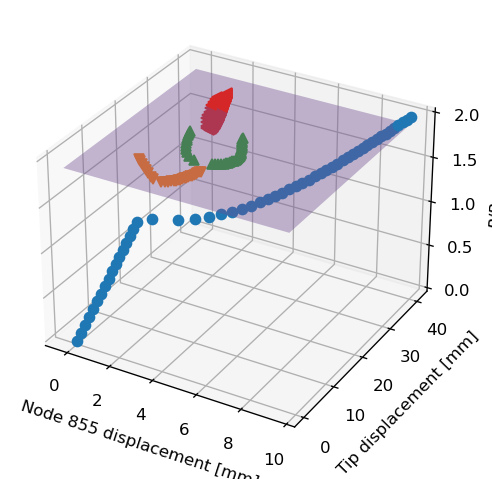

Deformation on natural path:


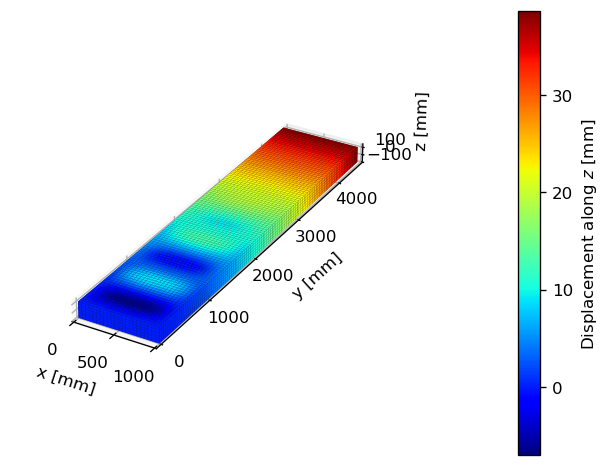

Deformations on unstable path:


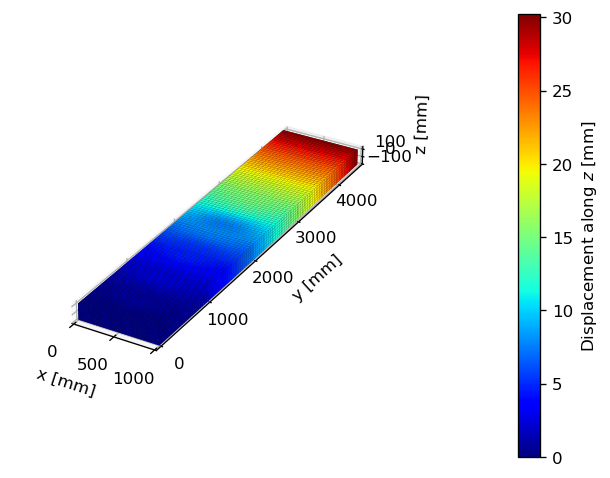

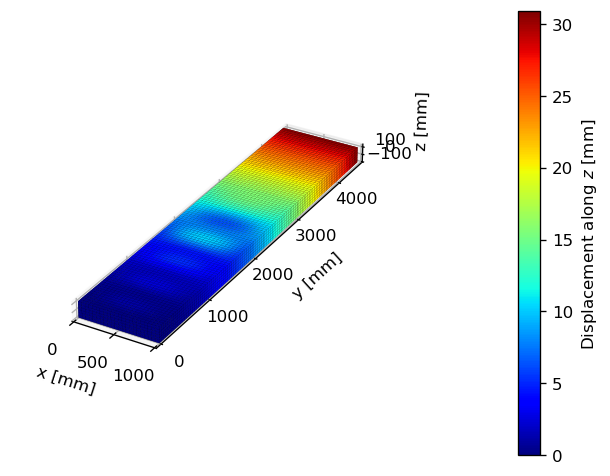

In [270]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')

# Plot part of the equilibrium paths that should not be visible on top of the plane
load_factor = 1.9
for key in local_displacements:
    ax_3d.plot3D(local_displacements[key], tip_displacements[key], np.where(applied_loads[key]<load_factor, applied_loads[key], np.nan), markers[key], color=colors[key])

# Plot plane
local_displacements_array = np.concatenate(tuple(local_displacements[key] for key in local_displacements))
tip_displacements_array = np.concatenate(tuple(tip_displacements[key] for key in tip_displacements))
xx, yy = np.meshgrid([np.min(local_displacements_array), np.max(local_displacements_array)], [np.min(tip_displacements_array), np.max(tip_displacements_array)])
ax_3d.plot_surface(xx, yy, np.full_like(xx, load_factor), alpha=0.4, color=colors[len(local_displacements)])

# Plot part of the equilibrium paths that should be visible on top of the plane
for key in local_displacements:
    ax_3d.plot3D(local_displacements[key], tip_displacements[key], np.where(applied_loads[key]>=load_factor, applied_loads[key], np.nan), markers[key], color=colors[key], zorder=3)

# Set plot appearance
ax_3d.set_xlabel(f'Node {max_displacement_node_id:d} displacement [mm]')
ax_3d.set_ylabel('Tip displacement [mm]')
ax_3d.set_zlabel('$P/P_\mathrm{SOL\/105}$')
ax_3d.grid(visible=True)
plt.show()

# Plot static deformation of natural path
print('Deformation on natural path:')
load_step = np.argmin(np.abs(applied_loads[0] - load_factor)) + 1  # find closest load step to plane
_, ax = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_2Psol105_epsp1em3, subcase_id=second_subcase_id, load_step=load_step, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

# Plot first deformation on unstable path
print('Deformations on unstable path:')
key = 3
negative_displacements_indices = np.where(local_displacements[key] < np.median(local_displacements[key]))[0]
load_step = negative_displacements_indices[np.argmin(np.abs(applied_loads[key][negative_displacements_indices] - load_factor))] + 1  # find closest load step to plane
_, ax = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_2Psol105_epsp1em1, subcase_id=second_subcase_id, load_step=load_step, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

# Plot second deformation on unstable path
positive_displacements_indices = np.where(local_displacements[key] > np.median(local_displacements[key]))[0]
load_step = positive_displacements_indices[np.argmin(np.abs(applied_loads[key][positive_displacements_indices] - load_factor))] + 1  # find closest load step to plane
_, ax = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_2Psol105_epsp1em1, subcase_id=second_subcase_id, load_step=load_step, displacement_component='tz')
set_ticks_and_labels_position(ax)
plt.show()

## Conclusions <a name="conclusions"></a>

***

In this notebook we have verified the existence of other equilibrium paths of the box beam reinforced with ribs. More specifically, we were able to find three different unstable paths that resulted to be disconnected from the natural one. Similarly to our last notebook, this was possible by choosing very coarse arc-length and by playing around with the convergence tolerances of the nonlinear analysis. The same caveats and reflections apply here as well. In addition, we notice how with the addition of the ribs, the equilibrium manifold seems to get more crowded with respect to what we observed for the unreinforced box beam. However, this is only an impression based on the obtained results, which however are not based on a systematic approach, as explained in our last notebook.

In the [next notebook](16_Investigation_of_the_Equilibrium_Paths_of_the_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb) we are going to perform an analogous investigation on the box beam reinforced with ribs and stiffeners.